In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Total loaded images: 2152
Total loaded masks: 2152
Training set size: 1506
Validation set size: 323
Test set size: 323
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


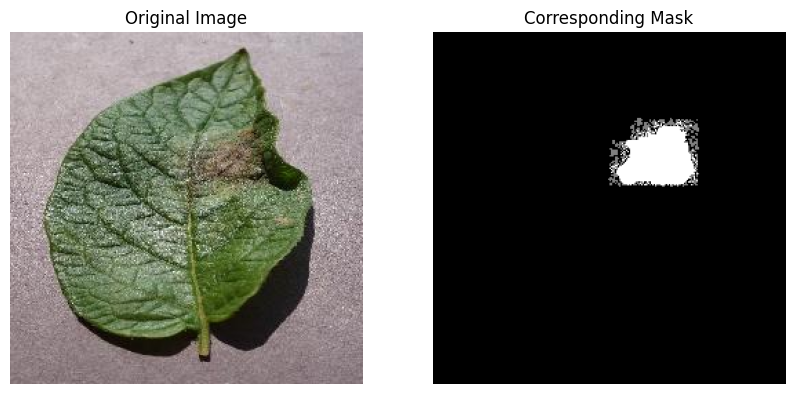

Epoch 1/200


I0000 00:00:1732467147.853056     104 service.cc:145] XLA service 0x7f11a810d290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732467147.853111     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732467147.853116     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732467218.842459     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.4442 - loss: 1.2129 - val_accuracy: 0.7172 - val_loss: 0.8075
Epoch 2/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step - accuracy: 0.7364 - loss: 0.7459 - val_accuracy: 0.7387 - val_loss: 0.6530
Epoch 3/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 769ms/step - accuracy: 0.7529 - loss: 0.6182 - val_accuracy: 0.7651 - val_loss: 0.5786
Epoch 4/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 781ms/step - accuracy: 0.7713 - loss: 0.5647 - val_accuracy: 0.7965 - val_loss: 0.5535
Epoch 5/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 769ms/step - accuracy: 0.8001 - loss: 0.5203 - val_accuracy: 0.8262 - val_loss: 0.4714
Epoch 6/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - accuracy: 0.8291 - loss: 0.4642 - val_accuracy: 0.8446 - val_loss: 0.4321
Epoch 7/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 772ms/step - accuracy: 0.8402 - loss: 0.4422 - val_accuracy: 0.8590 - val_loss: 0.4030
Epoch 8/200
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - accuracy: 0.8558 - loss: 0.4055 - val_accuracy: 

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data(image_dir, mask_dir, target_size=(256, 256)):
    images = []
    masks = []

    num_classes = 3 
    
    sub_dirs = sorted(os.listdir(image_dir))
    
    for sub_dir in sub_dirs:
        sub_image_dir = os.path.join(image_dir, sub_dir)
        sub_mask_dir = os.path.join(mask_dir, sub_dir)

        image_filenames = sorted(os.listdir(sub_image_dir))
        mask_filenames = sorted(os.listdir(sub_mask_dir))

        assert len(image_filenames) == len(mask_filenames), f"Mismatch in number of images and masks in {sub_dir}."

        for img_filename, mask_filename in zip(image_filenames, mask_filenames):
            img_path = os.path.join(sub_image_dir, img_filename)
            mask_path = os.path.join(sub_mask_dir, mask_filename)

            img = load_img(img_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode='grayscale')

            img_array = img_to_array(img) / 255.0
            mask_array = img_to_array(mask).astype(np.int32).squeeze()

            # Clip pixel values to valid range
            mask_array = np.clip(mask_array, 0, num_classes - 1)

            # One-hot encode the mask
            num_classes = 3  # Update this based on your mask's pixel values
            mask_array = to_categorical(mask_array, num_classes=num_classes)

            images.append(img_array)
            masks.append(mask_array)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks



# Define U-Net model
import tensorflow as tf
from tensorflow.keras import layers, models
def build_fcn(input_size=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_size)

    # Encoder: Pretrained backbone (e.g., VGG16)
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Use the feature maps from specific layers
    f1 = base_model.get_layer('block1_pool').output
    f2 = base_model.get_layer('block2_pool').output
    f3 = base_model.get_layer('block3_pool').output
    f4 = base_model.get_layer('block4_pool').output
    f5 = base_model.get_layer('block5_pool').output

    # Decoder: Fully convolutional layers
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(f5)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Upsampling with skip connections
    x = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, f4])
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, f3])
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, f2])
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.concatenate([x, f1])
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Final layer for segmentation output with upsampling to match 256x256
    x = layers.Conv2DTranspose(num_classes, (2, 2), strides=(2, 2), padding='same')(x)

    outputs = layers.Softmax()(x)  # Multi-class segmentation

    model = models.Model(inputs, outputs)
    return model


    

   
    

# Load and preprocess data
image_dir = '/kaggle/input/dataset-original/Original'# Path to the directory containing original images
mask_dir = '/kaggle/input/dataset-mask/mask'      # Path to the directory containing mask images

X, y = load_and_preprocess_data(image_dir, mask_dir)
print(f"Total loaded images: {len(X)}")
print(f"Total loaded masks: {len(y)}")

# Split data into training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Build the U-Net model
model = build_fcn(input_size=(256, 256, 3))
import matplotlib.pyplot as plt

# Function to display an image and its mask
def display_image_and_mask(image, mask):
    # Mask may be one-hot encoded; convert it to a single channel for visualization
    mask_single_channel = np.argmax(mask, axis=-1)

    # Plot the image and mask
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # Corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask_single_channel, cmap="gray")
    plt.title("Corresponding Mask")
    plt.axis("off")

    plt.show()

# Example: Display one image and mask from the training set
index = 15  # Index of the image to display
display_image_and_mask(X_train[index], y_train[index])


# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Optionally, evaluate the model
# model.evaluate(X_val, y_val)
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [3]:
val_loss, val_accuracy = model.evaluate(X_val, y_val, batch_size=32)

print(f"Val Loss: {val_loss}")
print(f"Val Accuracy: {val_accuracy}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8768 - loss: 0.5848
Val Loss: 0.5634416937828064
Val Accuracy: 0.8786858916282654


Evaluating the model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8764 - loss: 0.5845
Test Loss: 0.6030584573745728
Test Accuracy: 0.8788937926292419


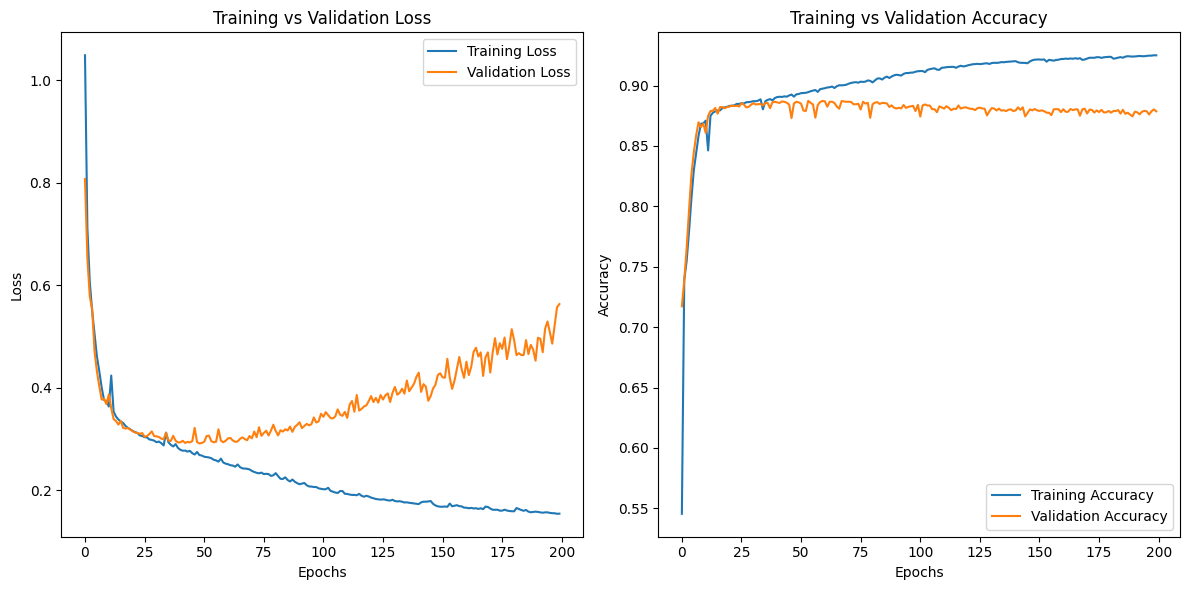

In [5]:
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
model.save_weights('/kaggle/working/model_weights/fcn_model.weights.h5')
print("Model weights saved successfully.")


Model weights saved successfully.


In [7]:
weights_file = '/kaggle/working/model_weights/fcn_model.weights.h5'

if os.path.exists(weights_file):
    model.load_weights(weights_file)
    print("Model weights loaded successfully.")
else:
    print(f"Model weights file '{weights_file}' not found.")


Model weights loaded successfully.


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step


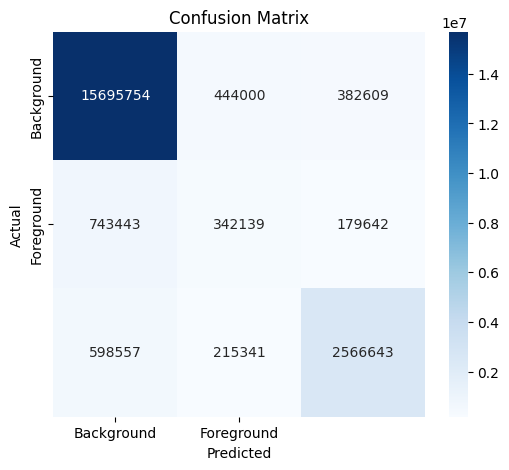

Confusion Matrix:
[[15695754   444000   382609]
 [  743443   342139   179642]
 [  598557   215341  2566643]]


In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the validation or test dataset
y_pred = model.predict(X_test)  # Use X_val if you want validation results

# Assuming y_test contains the actual labels for the test set, and y_pred is a probability map (for segmentation, etc.)
# For binary classification or segmentation, you need to convert the predictions to class labels (e.g., 0 for background, 1 for foreground)
y_pred_classes = np.argmax(y_pred, axis=-1)  # Use np.argmax for multi-class predictions (e.g., segmentation masks)

# If this is a binary classification task (e.g., background=0, foreground=1), use:
# y_pred_classes = (y_pred > 0.5).astype(int)  # For binary classification

# Convert the ground truth to class labels (if necessary)
y_true_classes = np.argmax(y_test, axis=-1)  # For segmentation or multi-class, use argmax to get class labels

# Compute confusion matrix
cm = confusion_matrix(y_true_classes.flatten(), y_pred_classes.flatten())

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Foreground'], yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix
print(f"Confusion Matrix:\n{cm}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


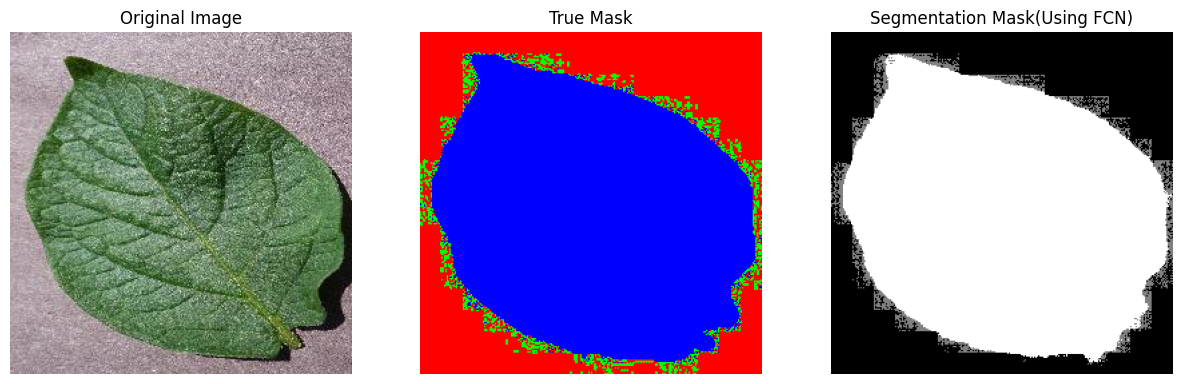

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Choose an index from the validation set (X_val)
random_index = 26  # You can select any specific index here

# Select the image and the corresponding true mask
image_to_test = X_val[random_index]
true_mask = y_val[random_index]

# Predict the mask for the selected image
predicted_mask = model.predict(np.expand_dims(image_to_test, axis=0))  # Add batch dimension

# If the predicted mask is one-hot encoded, convert it to class labels
predicted_mask_class = np.argmax(predicted_mask, axis=-1).squeeze()

# Plot the original image, true mask, and predicted mask
def plot_image_and_masks(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot true mask in grayscale
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='jet')
    plt.title("True Mask")
    plt.axis('off')

    # Plot predicted mask in grayscale
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')  # Grayscale colormap for predicted mask
    plt.title("Segmentation Mask(Using FCN)")
    plt.axis('off')

    plt.show()

# Display the image, true mask, and predicted mask
plot_image_and_masks(image_to_test, true_mask, predicted_mask_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


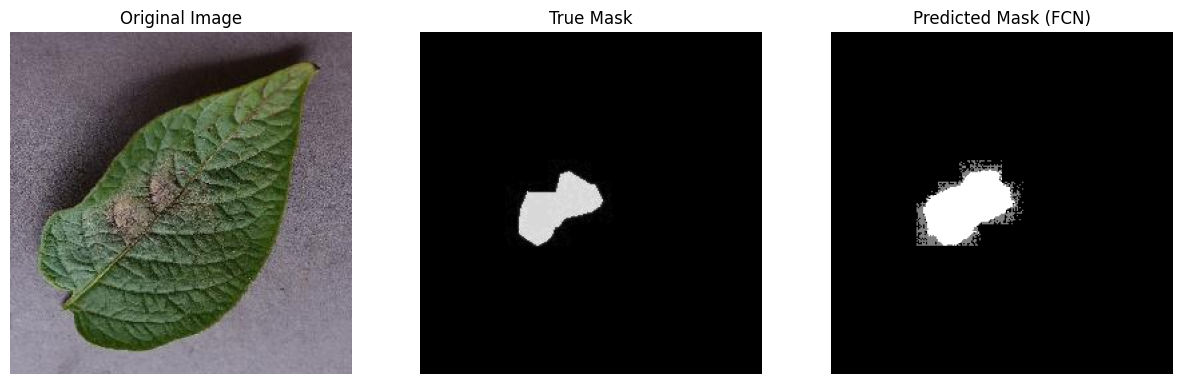

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load a random image from the dataset directory (including subdirectories)
def load_random_image(image_dir, mask_dir):
    # Get a list of all image files in the subdirectories (if any)
    image_files = []
    for subdir in os.listdir(image_dir):
        subdir_path = os.path.join(image_dir, subdir)
        if os.path.isdir(subdir_path):
            # If it's a directory, get the image files inside it
            image_files.extend([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
    
    # Check if there are any image files found
    if not image_files:
        raise ValueError(f"No image files found in {image_dir} or its subdirectories.")
    
    # Choose a random image file
    random_image_file = np.random.choice(image_files)
    
    # Try to find the corresponding mask by matching the base filename (without extensions)
    mask_filename = os.path.basename(random_image_file)  # Get the filename of the image
    mask_filename_without_extension = os.path.splitext(mask_filename)[0]  # Remove the extension

    # Search for the mask file in the mask directory
    mask_files = []
    for subdir in os.listdir(mask_dir):
        subdir_path = os.path.join(mask_dir, subdir)
        if os.path.isdir(subdir_path):
            # If it's a directory, get the mask files inside it
            mask_files.extend([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])

    # Find the mask file that matches the base filename of the image (with any extension)
    mask_path = None
    for mask_file in mask_files:
        if mask_filename_without_extension in mask_file:
            mask_path = mask_file
            break
    
    if mask_path is None:
        raise FileNotFoundError(f"No mask file found for {random_image_file}")
    
    # Load the image and corresponding mask
    image = load_img(random_image_file, target_size=(256, 256))  # Resize to match model input
    mask = load_img(mask_path, color_mode="grayscale", target_size=(256, 256))  # Load mask in grayscale
    
    # Convert the image and mask to numpy arrays
    image_array = img_to_array(image) / 255.0  # Normalize image
    mask_array = img_to_array(mask) / 255.0  # Normalize mask
    
    return image_array, mask_array

# Load a random image and its corresponding mask
image_dir = '/kaggle/input/dataset-original/Original'  # Path to the directory containing original images
mask_dir = '/kaggle/input/dataset-mask/mask'      # Path to the directory containing mask images

image_to_test, true_mask = load_random_image(image_dir, mask_dir)

# Predict the mask for the selected image
predicted_mask = model.predict(np.expand_dims(image_to_test, axis=0))  # Add batch dimension

# If the predicted mask is one-hot encoded, convert it to class labels
predicted_mask_class = np.argmax(predicted_mask, axis=-1).squeeze()

# Plot the original image, true mask, and predicted mask
def plot_image_and_masks(image, true_mask, predicted_mask):
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot true mask in grayscale
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    # Plot predicted mask in grayscale
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')  # Grayscale colormap for predicted mask
    plt.title("Predicted Mask (FCN)")
    plt.axis('off')

    plt.show()

# Display the image, true mask, and predicted mask
plot_image_and_masks(image_to_test, true_mask, predicted_mask_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


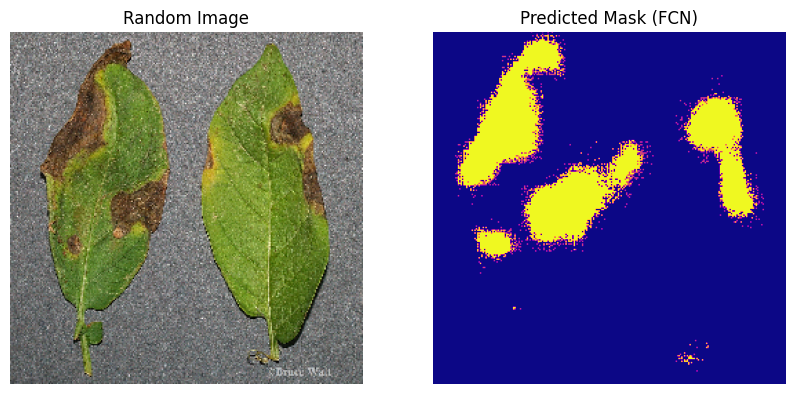

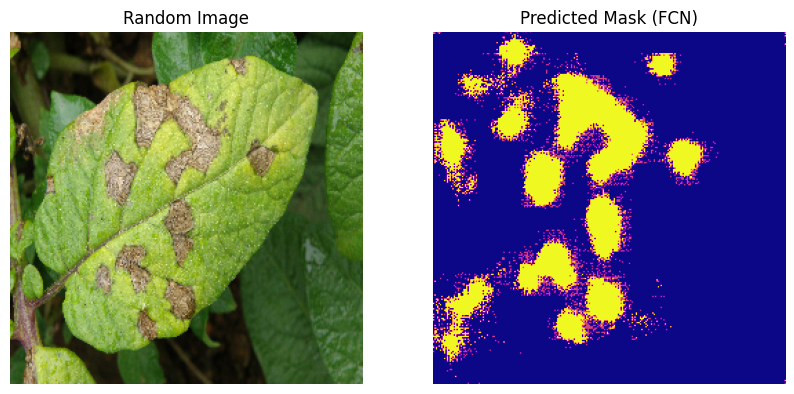

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the random image
random_image_path = '/kaggle/input/random-1/potato_leaves.jpg'
random_image_path_1 = '/kaggle/input/random-2/potato_leaves_1.jpg'

# Function to load and preprocess a single image
def load_and_preprocess_single_image(image_path, target_size=(256, 256)):
    # Load the image and resize to the target size
    image = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array and normalize it
    image_array = img_to_array(image) / 255.0  # Normalize image
    return image_array

# Load and preprocess the random image
random_image = load_and_preprocess_single_image(random_image_path)
random_image_1 = load_and_preprocess_single_image(random_image_path_1)
# Predict the segmentation mask for the random image
predicted_mask = model.predict(np.expand_dims(random_image, axis=0))
predicted_mask_1 = model.predict(np.expand_dims(random_image_1, axis=0))# Add batch dimension

# If the predicted mask is one-hot encoded, convert it to class labels
predicted_mask_class = np.argmax(predicted_mask, axis=-1).squeeze()
predicted_mask_class_1 = np.argmax(predicted_mask_1, axis=-1).squeeze()

# Plot the random image and its predicted mask
def plot_random_image_and_mask(image, predicted_mask, colormap='viridis'):
    plt.figure(figsize=(10, 5))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Random Image")
    plt.axis('off')

    # Plot the predicted mask with a colorized colormap
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap=colormap)
    plt.title("Predicted Mask (FCN)")
    plt.axis('off')

    plt.show()

# Display the random image and its predicted mask
plot_random_image_and_mask(random_image, predicted_mask_class, colormap='plasma')
plot_random_image_and_mask(random_image_1, predicted_mask_class_1, colormap='plasma')